In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import loguniform
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
import csv
import random
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
import warnings
%matplotlib inline
import os



In [2]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = 'a7e473a25f91d534f833232b746c044a'
os.environ["KAGGLE_USERNAME"] = 'jaiswaladityaranjit'

!kaggle datasets download -d jessicali9530/lfw-dataset


!unzip "lfw-dataset.zip"

Streaming output truncated to the last 5000 lines.
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0022.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0023.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0024.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0025.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0026.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0027.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0028.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Silva/Luiz_Inacio_Lula_da_Silva_0029.jpg  
  inflating: lfw-deepfunneled/lfw-deepfunneled/Luiz_Inacio_Lula_da_Si

In [3]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
from skimage.io import imread
from skimage.transform import resize
from skimage.feature import hog
import cv2

# Load pre-trained ResNet-50 model
resnet = models.resnet50(pretrained=True)
# Remove the last fully connected layer
resnet = nn.Sequential(*list(resnet.children())[:-1])
# Set the model to evaluation mode
resnet.eval()




def get_pixel(img, center, x, y):
    new_value = 0
    try:
        if img[x][y] >= center:
            new_value = 1
    except:
        pass
    return new_value

def lbp_calculated_pixel(img, x, y):
    center = img[x][y]
    val_ar = []
    val_ar.append(get_pixel(img, center, x-1, y+1))     # top_right
    val_ar.append(get_pixel(img, center, x, y+1))       # right
    val_ar.append(get_pixel(img, center, x+1, y+1))     # bottom_right
    val_ar.append(get_pixel(img, center, x+1, y))       # bottom
    val_ar.append(get_pixel(img, center, x+1, y-1))     # bottom_left
    val_ar.append(get_pixel(img, center, x, y-1))       # left
    val_ar.append(get_pixel(img, center, x-1, y-1))     # top_left
    val_ar.append(get_pixel(img, center, x-1, y))       # top

    power_val = [1, 2, 4, 8, 16, 32, 64, 128]
    val = 0
    for i in range(len(val_ar)):
        val += val_ar[i] * power_val[i]
    return val


def calcLBP(img):
    height, width, channel = img.shape
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img_lbp = np.zeros((height, width,3), np.uint8)
    for i in range(0, height):
        for j in range(0, width):
             img_lbp[i, j] = lbp_calculated_pixel(img_gray, i, j)
    hist_lbp = cv2.calcHist([img_lbp], [0], None, [256], [0, 256])
    return(hist_lbp)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:02<00:00, 47.9MB/s]


In [4]:
lfw_folder = '/content/lfw-deepfunneled/lfw-deepfunneled'
X, y = [], []
for folder_name in os.listdir(lfw_folder):
    folder_path = os.path.join(lfw_folder, folder_name)
    if os.path.isdir(folder_path):
        num_images = len(os.listdir(folder_path))
        if num_images > 70:
            for image_name in os.listdir(folder_path):
                image_path = os.path.join(folder_path, image_name)
                image = imread(image_path)
                # hog_feature = compute_hog(image)
                lbp_feature = calcLBP(image)
                # lbp_feature = extract_features(image_path, resnet).numpy()
                # hog_feature = hog_feature.reshape(-1)
                # lbp_feature = lbp_feature.reshape(-1)
                lbp_feature = lbp_feature.flatten()
                # combined_feature = np.concatenate((cnn_feature))

                X.append(lbp_feature)
                y.append(folder_name)

In [5]:
X_array = np.array(X)
Y_array = np.array(y)

In [6]:
print(X_array.shape)
print(Y_array.shape)

(1288, 256)
(1288,)


In [7]:
X_array[0].shape

(256,)

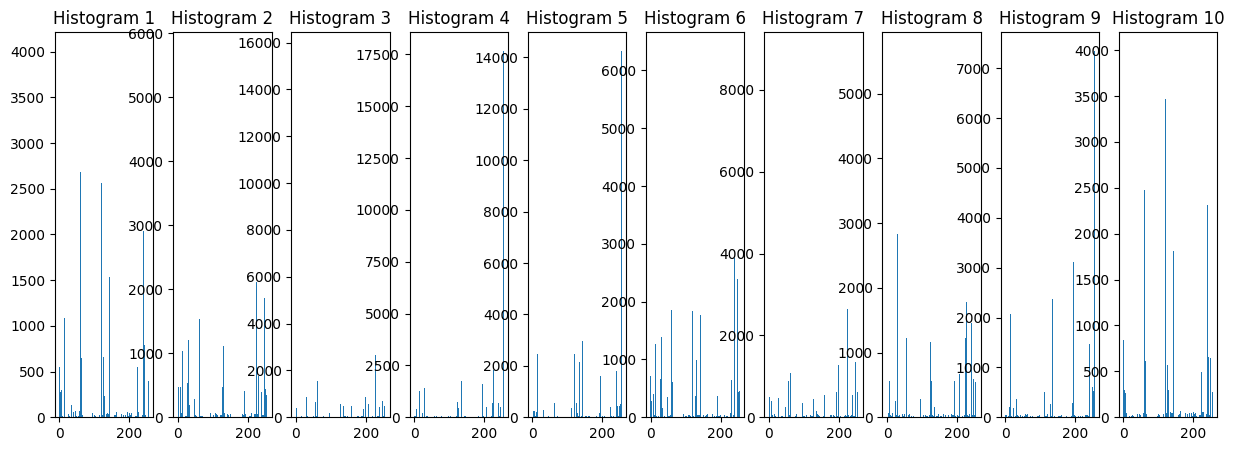

In [8]:
plt.figure(figsize=(15, 5))
for i in range(10):
    hist = X_array[i]
    plt.subplot(1, 10, i+1)
    plt.bar(range(len(hist)), hist)
    plt.title(f"Histogram {i+1}")
plt.show()

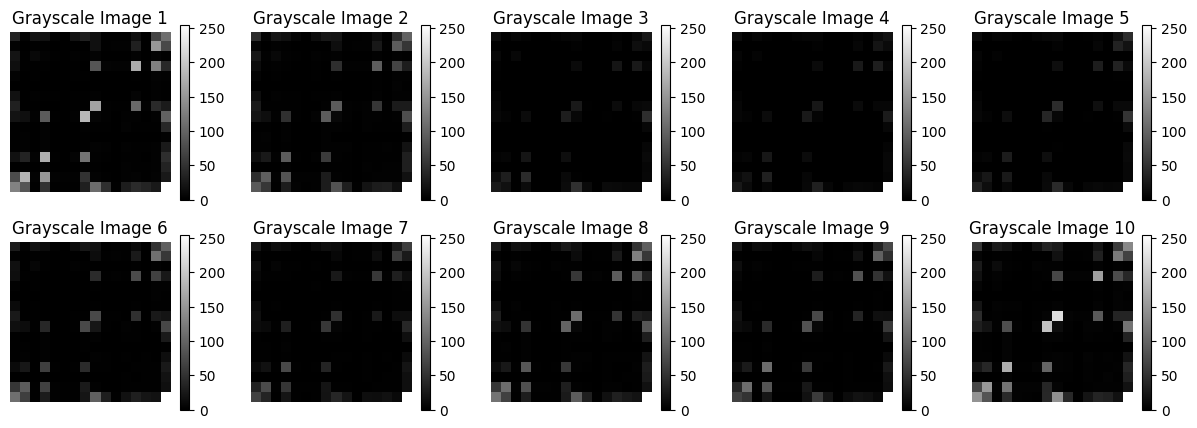

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Example array containing histograms of LBP features for each image
 # Assuming 10 samples

# Define a function to normalize the histogram values to [0, 255]
def normalize_histogram(hist):
    hist_min = np.min(hist)
    hist_max = np.max(hist)
    return ((hist - hist_min) / (hist_max - hist_min)) * 255

# Plot grayscale images corresponding to LBP histograms
plt.figure(figsize=(15, 5))
for i in range(10):
    hist = X_array[i]
    normalized_hist = normalize_histogram(hist)
    grayscale_image = normalized_hist.reshape(16, 16)
    plt.subplot(2, 5, i+1)
    plt.imshow(grayscale_image, cmap='gray')
    plt.colorbar()
    plt.title(f"Grayscale Image {i+1}")
    plt.axis('off')
plt.show()


In [10]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Initialize the LDA model
lda = LinearDiscriminantAnalysis()

# Fit the LDA model to the data
lda.fit(X_array, Y_array)

LinearDiscriminantAnalysis()

In [11]:
print(lda.coef_.shape)

(7, 256)


(256, 6)


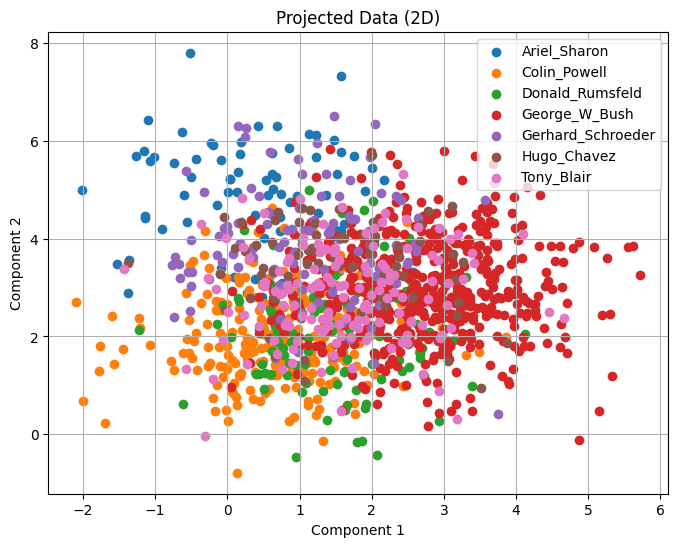

In [12]:
# Get the sorted eigenvalues and eigenvectors
eigenvalues = lda.explained_variance_ratio_
eigenvectors = lda.scalings_

# Sort eigenvalues and corresponding eigenvectors
sorted_indices = np.argsort(eigenvalues)[::-1]  # Sort in descending order
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]
print(sorted_eigenvectors.shape)
# Select the top 7 components
top_components = sorted_eigenvectors

# Project the data onto the top 7 components
X_projected = np.dot(X_array, top_components)

# Plot the projected data
plt.figure(figsize=(8, 6))
for label in np.unique(Y_array):
    plt.scatter(X_projected[Y_array == label, 0], X_projected[Y_array == label, 1], label=label)
plt.title('Projected Data (2D)')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.grid(True)
plt.show()

In [13]:
X_projected.shape  #so here the dimensionality reduced to 6 (n_classes-1, and in our data the number of classes are 7)

(1288, 6)

In [25]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X_projected,Y_array,test_size=0.3,random_state=42)

In [15]:


# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestClassifier

# param_grid = {
#     'n_estimators': range(1,200,10),
#     'max_depth': range(1,100,10),
#     'min_samples_split': [2],
#     'min_samples_leaf': range(1,50,10)
# }

# # Create Random Forest Classifier
# rf_classifier = RandomForestClassifier()

# # Perform grid search
# grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5)
# grid_search.fit(X_train, Y_train)

# # Print best parameters and best score
# print("Best Parameters:", grid_search.best_params_)
# print("Best Score:", grid_search.best_score_)





Best Parameters: {'max_depth': 91, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 151}
Best Score: 0.7147759361571516

In [16]:
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=151,max_depth=91,min_samples_split=2,min_samples_leaf=5)
rf_classifier.fit(X_train,y_train)
y_pred_rf = rf_classifier.predict(X_test)


from sklearn.metrics import accuracy_score
print(accuracy_score(y_test,y_pred_rf))

0.7157622739018088


In [17]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier()
from sklearn.model_selection import GridSearchCV
k_range = list(range(1, 31))
param_grid = dict(n_neighbors=k_range ,)
grid = GridSearchCV(neigh, param_grid, cv=10, scoring='accuracy', return_train_score=False)
grid.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30]},
             scoring='accuracy')

In [18]:
y_pred=grid.predict(X_test)

In [19]:
nn=grid.best_params_

In [20]:
from sklearn.metrics import accuracy_score
print("accuracy score whith knn with n_neighbors=",nn['n_neighbors'],"(best case) is:",accuracy_score(y_test, y_pred))

accuracy score whith knn with n_neighbors= 23 (best case) is: 0.7364341085271318


In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
# Define logistic regression classifier
logistic_regression = LogisticRegression(max_iter=200)

# Define the parameter grid for grid search
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'penalty': ['l1', 'l2'],  # Penalty term
}

# Create GridSearchCV object
grid_logistic_regression = GridSearchCV(logistic_regression, param_grid, cv=10, scoring='accuracy', return_train_score=False)

# Fit the model to the training data
grid_logistic_regression.fit(X_train, y_train)



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
60 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=200),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2']},
             scoring='accuracy')

In [22]:
# Print the best parameters and best score
print("Best parameters found: ", grid_logistic_regression.best_params_)
print("Best accuracy found: ", grid_logistic_regression.best_score_)

Best parameters found:  {'C': 10, 'penalty': 'l2'}
Best accuracy found:  0.7059462759462759


In [59]:
print(X_train)

[[ 0.31529654  0.89906026  0.46166326 -1.4751663  -1.19297405  0.11202443]
 [ 1.82082102  3.00051936 -1.12640812 -1.01403879  1.90731505  4.28347032]
 [-0.09608475  2.06102494  0.61829235 -1.60278942  0.29600143  1.3307532 ]
 ...
 [ 1.16191736  2.36622621 -2.12943747 -0.81604072  2.86374659  3.04941013]
 [ 0.72130326  1.66747937  0.4833923  -1.01278482 -0.41136857  1.63189634]
 [ 1.71830497  1.98626872 -1.93202256 -0.66903422  1.49378724  0.76289282]]


In [60]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB(var_smoothing=0.01)
gnb.fit(X_train,y_train)
y_pred_nvb = gnb.predict(X_test)
print(accuracy_score(y_test,y_pred_nvb))

0.7390180878552972


In [61]:
param_grid = {
    'var_smoothing': [1e-12, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
}
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print('best score',grid_search.best_score_)

Best parameters: {'var_smoothing': 0.01}
best score 0.7025782688766115


In [62]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Function to plot decision boundaries
def plot_decision_boundary(X, y, clf, title):
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.title(title)

In [63]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Linear SVM
svm_linear = SVC(kernel='linear',C=1)
svm_linear.fit(X_train, y_train)
y_pred_linear = svm_linear.predict(X_test)
print("Linear SVM Classification Report:")
print(classification_report(y_test, y_pred_linear))
print(accuracy_score(y_test,y_pred_linear))


Linear SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.77      0.71      0.74        24
     Colin_Powell       0.73      0.64      0.68        70
  Donald_Rumsfeld       0.54      0.67      0.60        30
    George_W_Bush       0.80      0.83      0.81       178
Gerhard_Schroeder       0.70      0.70      0.70        30
      Hugo_Chavez       0.71      0.71      0.71        17
       Tony_Blair       0.66      0.61      0.63        38

         accuracy                           0.74       387
        macro avg       0.70      0.69      0.70       387
     weighted avg       0.74      0.74      0.74       387

0.7364341085271318


In [66]:
# Polynomial SVM
svm_poly = SVC(kernel='poly', degree=2,C=1)  # You can adjust the degree parameter as needed
svm_poly.fit(X_train, y_train)
y_pred_poly = svm_poly.predict(X_test)
print("\nPolynomial SVM Classification Report:")
print(classification_report(y_test, y_pred_poly))
print(accuracy_score(y_test,y_pred_poly))



Polynomial SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.89      0.71      0.79        24
     Colin_Powell       0.65      0.70      0.68        70
  Donald_Rumsfeld       0.58      0.63      0.60        30
    George_W_Bush       0.78      0.82      0.80       178
Gerhard_Schroeder       0.73      0.63      0.68        30
      Hugo_Chavez       0.69      0.65      0.67        17
       Tony_Blair       0.69      0.58      0.63        38

         accuracy                           0.73       387
        macro avg       0.72      0.67      0.69       387
     weighted avg       0.73      0.73      0.73       387

0.7312661498708011


In [67]:
# RBF SVM
svm_rbf = SVC(kernel='rbf',C=100,gamma=0.001)
svm_rbf.fit(X_train, y_train)
y_pred_rbf = svm_rbf.predict(X_test)
print("\nRBF SVM Classification Report:")
print(classification_report(y_test, y_pred_rbf))
print(accuracy_score(y_test,y_pred_rbf))


RBF SVM Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.81      0.71      0.76        24
     Colin_Powell       0.70      0.67      0.69        70
  Donald_Rumsfeld       0.54      0.63      0.58        30
    George_W_Bush       0.79      0.83      0.81       178
Gerhard_Schroeder       0.74      0.67      0.70        30
      Hugo_Chavez       0.71      0.71      0.71        17
       Tony_Blair       0.70      0.61      0.65        38

         accuracy                           0.74       387
        macro avg       0.71      0.69      0.70       387
     weighted avg       0.74      0.74      0.74       387

0.7390180878552972


In [68]:


# Define parameter grids for each SVM kernel type
param_grid_linear = {
    'C': [0.01, 0.1, 1, 10, 100]  # Regularization parameter C
}

param_grid_poly = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'degree': [2, 3, 4],  # Polynomial degree
}

param_grid_rbf = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter C
    'gamma': [0.001, 0.01, 0.1, 1, 10]  # RBF kernel width
}

# Perform grid search for each SVM kernel type
grid_search_linear = GridSearchCV(estimator=SVC(kernel='linear'), param_grid=param_grid_linear, cv=5, scoring='accuracy')
grid_search_linear.fit(X_train, y_train)
print("Best parameters for Linear SVM:", grid_search_linear.best_params_)

grid_search_poly = GridSearchCV(estimator=SVC(kernel='poly'), param_grid=param_grid_poly, cv=5, scoring='accuracy')
grid_search_poly.fit(X_train, y_train)
print("Best parameters for Polynomial SVM:", grid_search_poly.best_params_)

grid_search_rbf = GridSearchCV(estimator=SVC(kernel='rbf'), param_grid=param_grid_rbf, cv=5, scoring='accuracy')
grid_search_rbf.fit(X_train, y_train)
print("Best parameters for RBF SVM:", grid_search_rbf.best_params_)


Best parameters for Linear SVM: {'C': 1}
Best parameters for Polynomial SVM: {'C': 1, 'degree': 2}
Best parameters for RBF SVM: {'C': 100, 'gamma': 0.001}


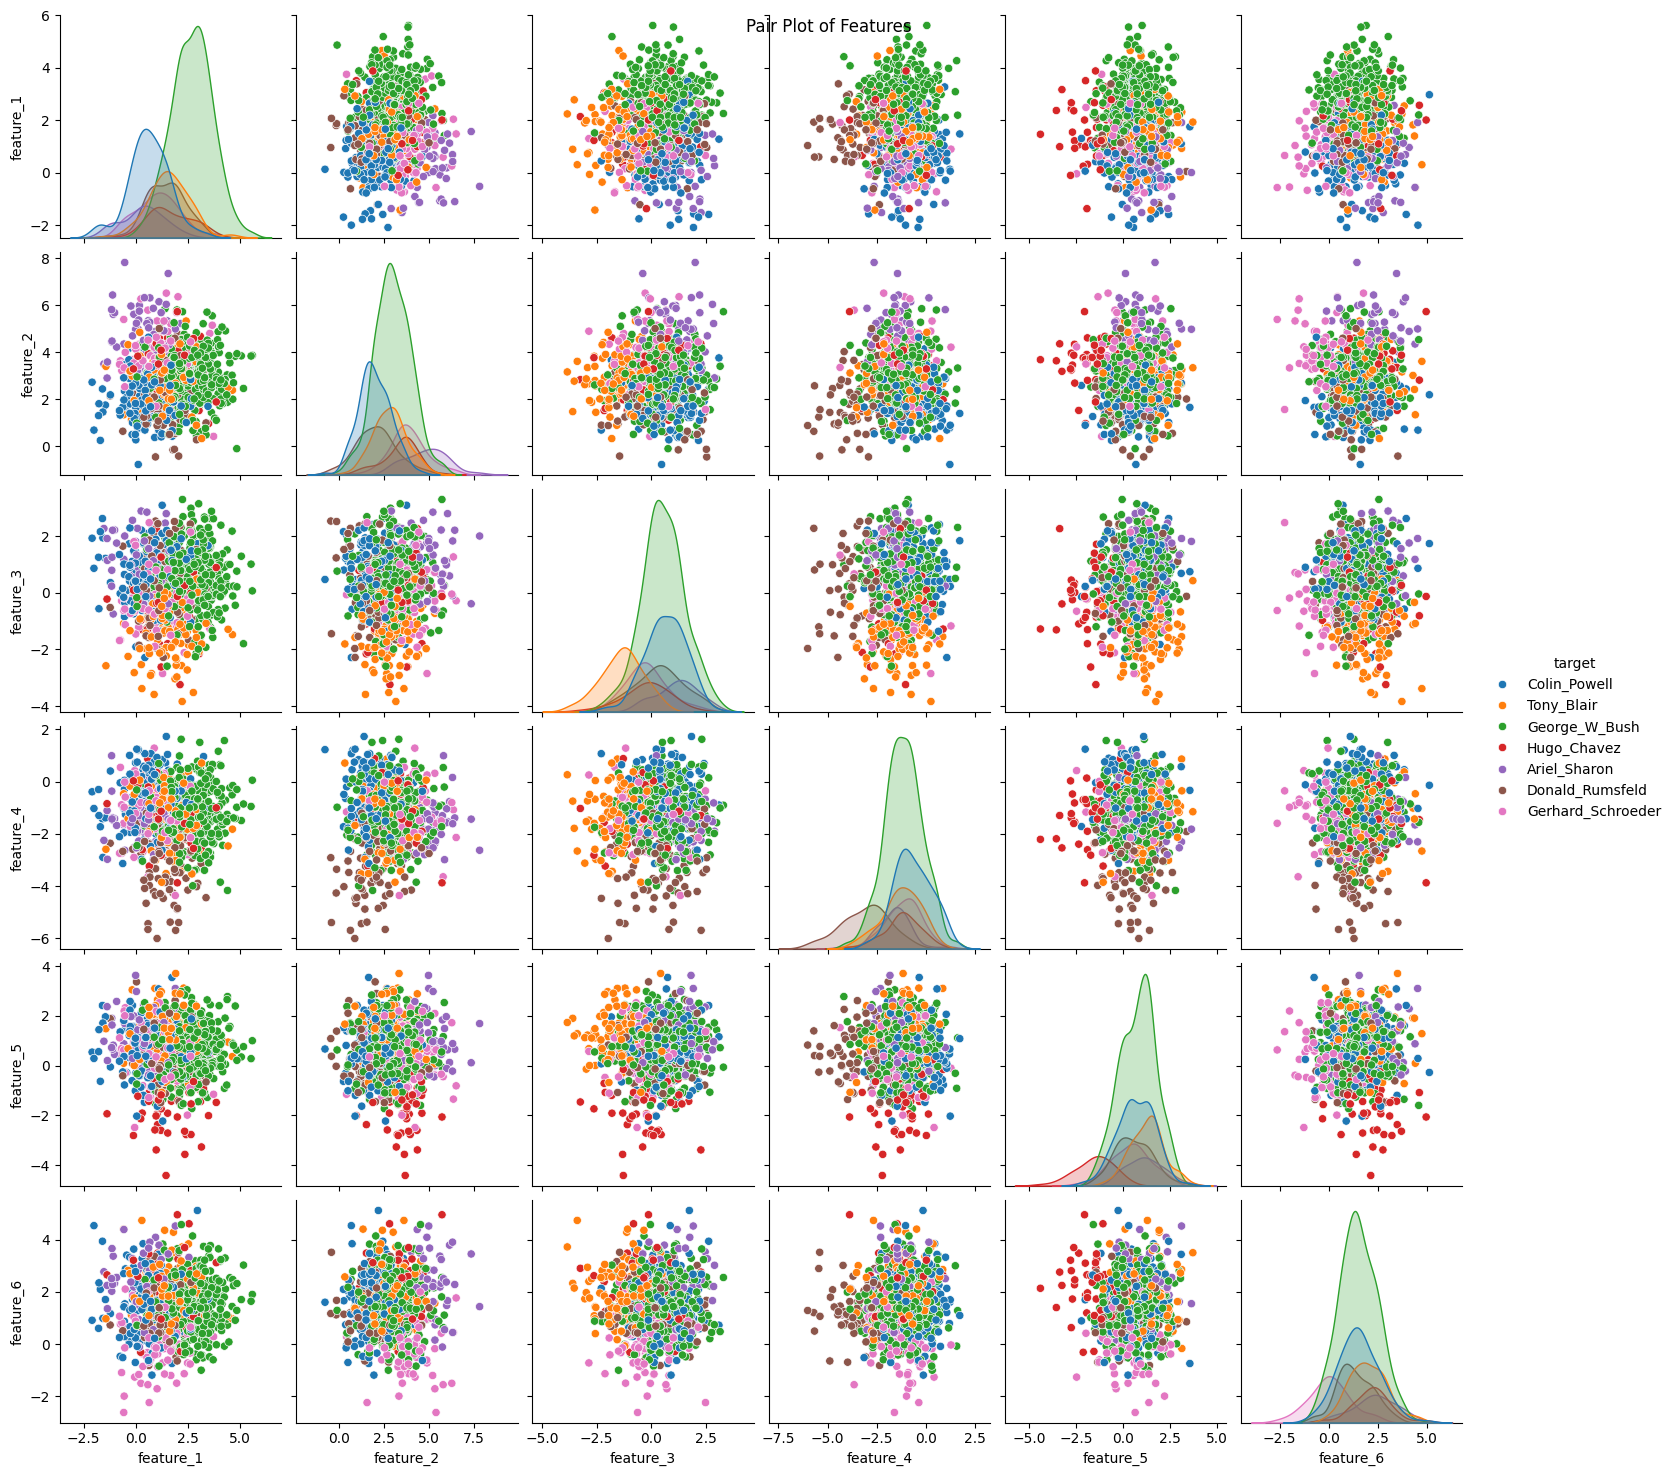

ValueError: The following variable cannot be assigned with wide-form data: `hue`

<Figure size 1000x600 with 0 Axes>

In [71]:
import seaborn as sns

# Convert training data to DataFrame for visualization
import pandas as pd
X_train_df = pd.DataFrame(X_train, columns=[f'feature_{i+1}' for i in range(X_train.shape[1])])
X_train_df['target'] = y_train

# Pair plot
sns.pairplot(X_train_df, hue='target', diag_kind='kde')
plt.suptitle("Pair Plot of Features")
plt.show()

# Parallel coordinates plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train_df, hue='target')
plt.title("Parallel Coordinates Plot of Features")
plt.show()


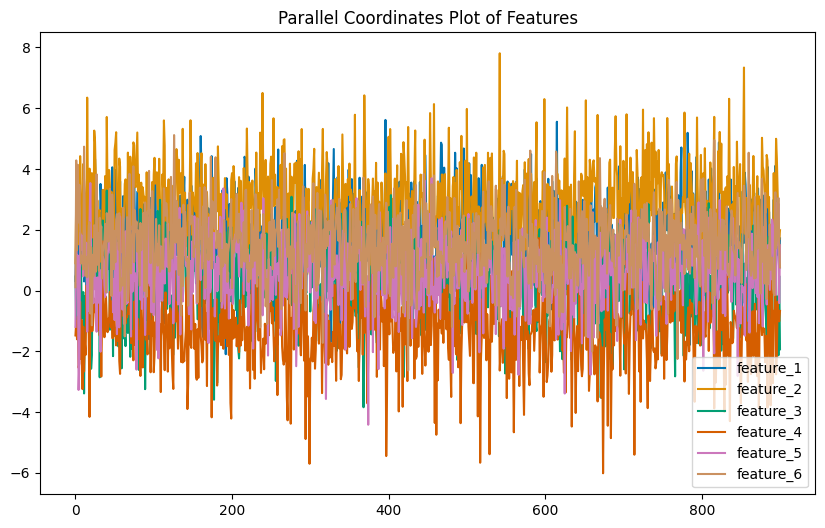

In [72]:
import seaborn as sns

# Convert training data to DataFrame for visualization
import pandas as pd
X_train_df = pd.DataFrame(X_train, columns=[f'feature_{i+1}' for i in range(X_train.shape[1])])
X_train_df['target'] = y_train

# Parallel coordinates plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=X_train_df.drop(columns='target'), dashes=False, palette='colorblind')
plt.title("Parallel Coordinates Plot of Features")
plt.show()


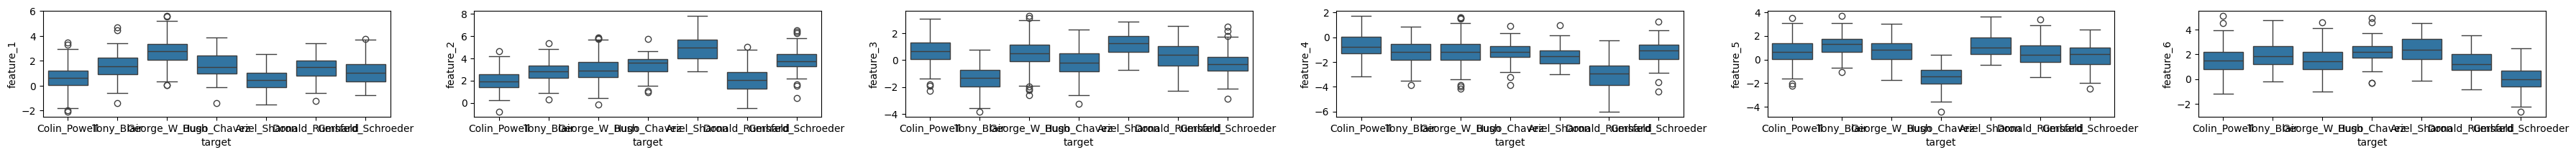

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Convert training data to DataFrame for visualization
import pandas as pd
X_train_df = pd.DataFrame(X_train, columns=[f'feature_{i+1}' for i in range(X_train.shape[1])])
X_train_df['target'] = y_train

# Plot box plots for each feature
plt.figure(figsize=(36, 12))
for i in range(X_train.shape[1]):
    plt.subplot(6, 6, i+1)
    sns.boxplot(x='target', y=f'feature_{i+1}', data=X_train_df)

plt.tight_layout()
plt.show()


In [94]:
from sklearn.preprocessing import LabelEncoder

# Convert class labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

In [95]:
print(np.unique(y_train_encoded))

[0 1 2 3 4 5 6]


In [96]:
from sklearn.neural_network import MLPClassifier

In [97]:
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000, random_state=42)
mlp_classifier.fit(X_train, y_train_encoded)

# Predict on the test set
y_pred_mlp = mlp_classifier.predict(X_test)

# Convert predictions back to original labels


# Calculate accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_mlp)
print("Accuracy:", accuracy)

Accuracy: 0.7416020671834626


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


In [98]:
from keras.models import Sequential
from keras.layers import Dense

In [102]:
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y_train)), activation='softmax'))

In [106]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train_encoded, epochs=15, batch_size=32, verbose=1,validation_split=0.2)

# Evaluate the model on test data
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print("Test Accuracy:", accuracy)

Epoch 1/15
23/23 [==============================] - 2s 25ms/step - loss: 0.6272 - accuracy: 0.7639 - val_loss: 0.5880 - val_accuracy: 0.7845
Epoch 2/15
23/23 [==============================] - 0s 11ms/step - loss: 0.6009 - accuracy: 0.7736 - val_loss: 0.5883 - val_accuracy: 0.7901
Epoch 3/15
23/23 [==============================] - 0s 9ms/step - loss: 0.5780 - accuracy: 0.7764 - val_loss: 0.6030 - val_accuracy: 0.7790
Epoch 4/15
23/23 [==============================] - 0s 9ms/step - loss: 0.5834 - accuracy: 0.7764 - val_loss: 0.6153 - val_accuracy: 0.7680
Epoch 5/15
23/23 [==============================] - 0s 8ms/step - loss: 0.5746 - accuracy: 0.7708 - val_loss: 0.6084 - val_accuracy: 0.7845
Epoch 6/15
23/23 [==============================] - 0s 9ms/step - loss: 0.5766 - accuracy: 0.7694 - val_loss: 0.6150 - val_accuracy: 0.7735
Epoch 7/15
23/23 [==============================] - 0s 9ms/step - loss: 0.5687 - accuracy: 0.7875 - val_loss: 0.6324 - val_accuracy: 0.7624
Epoch 8/15
23/23 [

In [ ]:
what are the things